# Milestone 2

In [1]:
import pandas as pd
import os
import numpy as np
import networkx as nx 
import urllib
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from scipy.spatial import distance
from scipy import linalg, mat, dot

pd.set_option('max_colwidth', 0) # use the screen width to display data

# Load data

In [2]:
# categories
df_categories = pd.read_csv('./data/wikispeedia_paths-and-graph/categories.tsv', sep='\t', header=None, comment='#')
df_categories.columns = ['article', 'category']
df_categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_Countries
4,%C3%89douard_Manet,subject.People.Artists


In [3]:
# finished paths
df_finished_paths = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', header=None, comment='#')
df_finished_paths.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F._Kennedy,3.0


In [4]:
# unfinished paths
df_unfinished_paths = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', header=None, comment='#')
df_unfinished_paths.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [5]:
# articles
df_articles = pd.read_csv('./data/wikispeedia_paths-and-graph/articles.tsv', sep='\t', header=None, comment='#')
df_articles.columns = ['article']
df_articles.head()

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


In [6]:
# links
df_links = pd.read_csv('./data/wikispeedia_paths-and-graph/links.tsv', sep='\t', header=None, comment='#')
df_links.columns = ['linkSource', 'linkTarget']
df_links.head()

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


# Missing data

In [7]:
# Some of the ratings are NaN (optional feedback from the user)

# Pre-processing

## Unquoting the names for all dataframes

In [8]:
df_categories.article = df_categories.article.apply(lambda x: urllib.parse.unquote(x))
df_categories.head(5)

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_Countries
4,Édouard_Manet,subject.People.Artists


In [9]:
df_finished_paths.path = df_finished_paths.path.apply(lambda x: urllib.parse.unquote(x))
df_finished_paths.head(5)

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F._Kennedy,3.0


In [10]:
df_unfinished_paths.path = df_unfinished_paths.path.apply(lambda x: urllib.parse.unquote(x))
df_unfinished_paths.target = df_unfinished_paths.target.apply(lambda x: urllib.parse.unquote(x))
df_unfinished_paths.head(5)

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [11]:
df_articles.article = df_articles.article.apply(lambda x: urllib.parse.unquote(x))
df_articles.head(5)

,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [12]:
df_links.linkSource = df_links.linkSource.apply(lambda x: urllib.parse.unquote(x))
df_links.linkTarget = df_links.linkTarget.apply(lambda x: urllib.parse.unquote(x))
df_links.head(5)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


## Split path into a list

In [13]:
df_finished_paths['path_list'] = df_finished_paths['path'].apply(lambda x: x.split(';'))
df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_list
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade,NaN,"[14th_century, 15th_century, 16th_century, Pacific_Ocean, Atlantic_Ocean, Accra, Africa, Atlantic_slave_trade, African_slave_trade]"
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,"[14th_century, Europe, Africa, Atlantic_slave_trade, African_slave_trade]"
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,"[14th_century, Niger, Nigeria, British_Empire, Slavery, Africa, Atlantic_slave_trade, African_slave_trade]"
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[14th_century, Renaissance, Ancient_Greece, Greece]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F._Kennedy,3.0,"[14th_century, Italy, Roman_Catholic_Church, HIV, Ronald_Reagan, President_of_the_United_States, John_F._Kennedy]"


In [14]:
df_unfinished_paths['path_list'] = df_unfinished_paths['path'].apply(lambda x: x.split(';'))
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,path_list
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,[Obi-Wan_Kenobi]
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,[Julius_Caesar]
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,"[Malawi, Democracy, Alexander_the_Great]"
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,[Paraguay]
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,"[Paraguay, Bolivia]"


## Create paths without backtracking

In [15]:
def removeBacktracking(path):
    st = []
    for p in path:
        if p == '<':
            if len(st) == 0:
                exit(1)
            st.pop()
        else:
            st.append(p)
    return st

In [16]:
df_finished_paths['path_list_without_backtracking'] = df_finished_paths['path_list'].apply(lambda x: removeBacktracking(x))
df_finished_paths['path_length_without_backtracking'] = df_finished_paths['path_list_without_backtracking'].apply(lambda x: len(x))
df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,path_list,path_list_without_backtracking,path_length_without_backtracking
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific_Ocean;Atlantic_Ocean;Accra;Africa;Atlantic_slave_trade;African_slave_trade,NaN,"[14th_century, 15th_century, 16th_century, Pacific_Ocean, Atlantic_Ocean, Accra, Africa, Atlantic_slave_trade, African_slave_trade]","[14th_century, 15th_century, 16th_century, Pacific_Ocean, Atlantic_Ocean, Accra, Africa, Atlantic_slave_trade, African_slave_trade]",9
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trade;African_slave_trade,3.0,"[14th_century, Europe, Africa, Atlantic_slave_trade, African_slave_trade]","[14th_century, Europe, Africa, Atlantic_slave_trade, African_slave_trade]",5
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slavery;Africa;Atlantic_slave_trade;African_slave_trade,NaN,"[14th_century, Niger, Nigeria, British_Empire, Slavery, Africa, Atlantic_slave_trade, African_slave_trade]","[14th_century, Niger, Nigeria, British_Empire, Slavery, Africa, Atlantic_slave_trade, African_slave_trade]",8
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[14th_century, Renaissance, Ancient_Greece, Greece]","[14th_century, Renaissance, Ancient_Greece, Greece]",4
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;Ronald_Reagan;President_of_the_United_States;John_F._Kennedy,3.0,"[14th_century, Italy, Roman_Catholic_Church, HIV, Ronald_Reagan, President_of_the_United_States, John_F._Kennedy]","[14th_century, Italy, Roman_Catholic_Church, HIV, Ronald_Reagan, President_of_the_United_States, John_F._Kennedy]",7


In [17]:
# debug 
df_finished_paths[df_finished_paths.path.str.contains('<')][['path', 'path_list_without_backtracking']]

,path,path_list_without_backtracking
10,14th_century;Time;Science;Nature;Weather;Sunlight;<;Sun;Earth's_atmosphere;Ultraviolet;Color;Light;Rainbow,"[14th_century, Time, Science, Nature, Weather, Sun, Earth's_atmosphere, Ultraviolet, Color, Light, Rainbow]"
13,14th_century;Renaissance;Empiricism;Nature;Weather;Sunlight;<;Rain;<;Sunlight;Earth's_atmosphere;<;<;Sun;Isaac_Newton;Rainbow,"[14th_century, Renaissance, Empiricism, Nature, Weather, Sun, Isaac_Newton, Rainbow]"
14,14th_century;Renaissance;Leonardo_da_Vinci;Water;Rain;Cloud;<;<;Rainbow,"[14th_century, Renaissance, Leonardo_da_Vinci, Water, Rainbow]"
16,14th_century;Europe;Republic_of_Ireland;<;<;Europe;<;Europe;Republic_of_Ireland;<;<;Time;Physics;Speed_of_light;Rainbow,"[14th_century, Time, Physics, Speed_of_light, Rainbow]"
19,14th_century;Time;Physics;<;Day;Sun;Sunlight;Ultraviolet;<;Earth's_atmosphere;<;Ultraviolet;Color;Rainbow,"[14th_century, Time, Day, Sun, Sunlight, Ultraviolet, Color, Rainbow]"
...,...,...
51290,Tropical_Storm_Matthew_(2004);United_States;Medicine;Health;<;Cancer;Virus;Smallpox;<;Edward_Jenner,"[Tropical_Storm_Matthew_(2004), United_States, Medicine, Cancer, Virus, Edward_Jenner]"
51298,Uluru;Australia;Continent;<;England;London;London_Bridge,"[Uluru, Australia, England, London, London_Bridge]"
51301,Valparaíso;World_Heritage_Site;Europe;<;United_Kingdom;United_Nations;<;European_Union;Greece;Ancient_Greece;Hellenistic_Greece,"[Valparaíso, World_Heritage_Site, United_Kingdom, European_Union, Greece, Ancient_Greece, Hellenistic_Greece]"
51312,Work_(thermodynamics);Cambridge;City_status_in_the_United_Kingdom;<;1st_century_BC;Korea;Pyongyang,"[Work_(thermodynamics), Cambridge, 1st_century_BC, Korea, Pyongyang]"


In [18]:
df_unfinished_paths['path_list_without_backtracking'] = df_unfinished_paths['path_list'].apply(lambda x: removeBacktracking(x))
df_unfinished_paths['path_length_without_backtracking'] = df_unfinished_paths['path_list_without_backtracking'].apply(lambda x: len(x))
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,path_list,path_list_without_backtracking,path_length_without_backtracking
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,[Obi-Wan_Kenobi],[Obi-Wan_Kenobi],1
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,[Julius_Caesar],[Julius_Caesar],1
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,"[Malawi, Democracy, Alexander_the_Great]","[Malawi, Democracy, Alexander_the_Great]",3
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,[Paraguay],[Paraguay],1
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,"[Paraguay, Bolivia]","[Paraguay, Bolivia]",2


In [19]:
# debug 
df_unfinished_paths[df_unfinished_paths.path.str.contains('<')][['path', 'path_list_without_backtracking']]

,path,path_list_without_backtracking
21,Potato;Europe;North_America;<;<,[Potato]
23,Ape;English_language;England;<,"[Ape, English_language]"
24,The_Shawshank_Redemption;English_language;European_Union;Russia;<;Russia,"[The_Shawshank_Redemption, English_language, European_Union, Russia]"
26,Second_Congo_War;World_War_II;United_Kingdom;Scotland;Glasgow;<;Outer_Hebrides;<,"[Second_Congo_War, World_War_II, United_Kingdom, Scotland]"
32,Aircraft;Hydrogen;<;Hydrogen;Iron;Steel;Metal;Corrosion,"[Aircraft, Hydrogen, Iron, Steel, Metal, Corrosion]"
...,...,...
24861,Breaker_Morant;England;The_Beatles;Sweden;Stockholm;<;Russia;Azerbaijan,"[Breaker_Morant, England, The_Beatles, Sweden, Russia, Azerbaijan]"
24862,Shaka;Napoleon_I_of_France;Belgium;Netherlands;Indonesia;Jakarta;Indonesian_language;<;<;Sumatra;Earthquake;<;2004_Indian_Ocean_earthquake;2005_Sumatra_earthquake,"[Shaka, Napoleon_I_of_France, Belgium, Netherlands, Indonesia, Sumatra, 2004_Indian_Ocean_earthquake, 2005_Sumatra_earthquake]"
24864,Sardar_Vallabhbhai_Patel;World_War_II;The_Holocaust;Austria;Anschluss;Adolf_Hitler;<;Nazi_Germany;The_Holocaust,"[Sardar_Vallabhbhai_Patel, World_War_II, The_Holocaust, Austria, Anschluss, Nazi_Germany, The_Holocaust]"
24870,Franz_Kafka;Tuberculosis;World_Health_Organization;Malaria;Philippines;<;Sub-Saharan_Africa;Ghana,"[Franz_Kafka, Tuberculosis, World_Health_Organization, Malaria, Sub-Saharan_Africa, Ghana]"


# Split categories

In [20]:
df_categories['category_list'] = df_categories.category.apply(lambda x: x.split('.'))
df_categories.head()

,article,category,category_list
0,Áedán_mac_Gabráin,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,"[subject, History, British_History, British_History_1500_and_before_including_Roman_Britain]"
1,Áedán_mac_Gabráin,subject.People.Historical_figures,"[subject, People, Historical_figures]"
2,Åland,subject.Countries,"[subject, Countries]"
3,Åland,subject.Geography.European_Geography.European_Countries,"[subject, Geography, European_Geography, European_Countries]"
4,Édouard_Manet,subject.People.Artists,"[subject, People, Artists]"


# Basic exploration

In [21]:
def get_sorted_dict_by_count(data, column_names):
    ret = []
    for k, v in data.items():
        ret.append((k, v))
    ret = sorted(ret, key=lambda x: x[1], reverse=True)
    df_ret = pd.DataFrame(ret, columns=column_names)
    
    return df_ret

In [22]:
# basic stat (path)
print("Total finished paths {}".format(len(df_finished_paths)))
print("Total unfinished paths {}".format(len(df_unfinished_paths)))
print("Max, min, avg, median finished path length (without backtracking) {} {} {} {}".format(df_finished_paths.path_length_without_backtracking.max(), df_finished_paths.path_length_without_backtracking.min(), df_finished_paths.path_length_without_backtracking.mean(), df_finished_paths.path_length_without_backtracking.median()))

Total finished paths 51318
Total unfinished paths 24875
Max, min, avg, median finished path length (without backtracking) 405 1 5.956116762149733 5.0


Percentage of the people that left feedback = 55.53801784948751%
Percentage of the people that left feedback think it's doable (rating [1, 3]) = 47.926653415955414%


<AxesSubplot: >

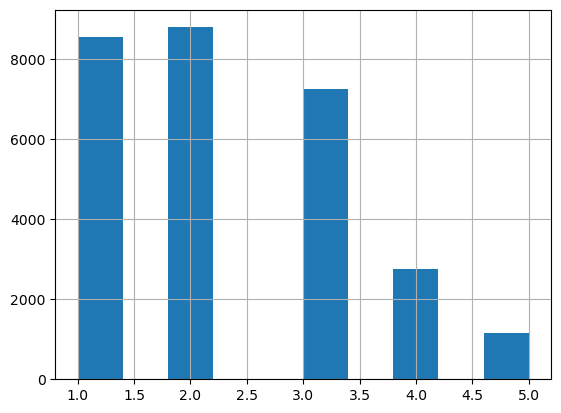

In [23]:
# Rating distribution
df_finished_paths_without_nan_rating = df_finished_paths.drop(df_finished_paths[df_finished_paths.rating.isna()].index)
print("Percentage of the people that left feedback = {}%".format(100.0 * len(df_finished_paths_without_nan_rating) / len(df_finished_paths)))
print("Percentage of the people that left feedback think it's doable (rating [1, 3]) = {}%".format(100.0 * len(df_finished_paths_without_nan_rating.drop(df_finished_paths_without_nan_rating[df_finished_paths_without_nan_rating.rating > 3.0].index)) / len(df_finished_paths)))
df_finished_paths_without_nan_rating.rating.hist()

In [24]:
# basic stat (category)
print("Total categories {}".format(len(df_categories)))

# articles per category
articles_per_category = {}
for i in range(0, len(df_categories)):
    if df_categories.iloc[i][1] in articles_per_category:
        articles_per_category[df_categories.iloc[i][1]] += 1
    else:
        articles_per_category[df_categories.iloc[i][1]] = 1

df_articles_per_category_sorted_by_article_count = get_sorted_dict_by_count(articles_per_category, ['Category', 'Article count'])
df_articles_per_category_sorted_by_article_count.head(15)

Total categories 5204


,Category,Article count
0,subject.Countries,229
1,subject.Science.Biology.Birds,161
2,subject.Geography.Geography_of_Great_Britain,124
3,subject.Science.Chemistry.Chemical_elements,119
4,subject.Science.Biology.Mammals,114
5,subject.Science.Biology.Health_and_medicine,109
6,subject.People.Historical_figures,108
7,subject.Science.Biology.Plants,108
8,subject.Science.Physics.Space_Astronomy,105
9,subject.Geography.North_American_Geography,103


In [25]:
# most visited pages by in-degree (finished only)

finished_paths_page_in_degree_count = {}
for path in df_finished_paths['path_list_without_backtracking']:
    is_first = True
    for hub_name in path:
        if is_first:
            is_first = False
            continue
        if hub_name in finished_paths_page_in_degree_count:
            finished_paths_page_in_degree_count[hub_name] += 1
        else:
            finished_paths_page_in_degree_count[hub_name] = 1
            
df_finished_paths_page_sorted_by_in_degree_count = get_sorted_dict_by_count(finished_paths_page_in_degree_count, ['Name', 'In-degree count'])
df_finished_paths_page_sorted_by_in_degree_count.head(15)

,Name,In-degree count
0,United_States,8541
1,Europe,4183
2,United_Kingdom,3669
3,Earth,3103
4,England,3028
5,Africa,2629
6,World_War_II,2160
7,North_America,1741
8,Germany,1645
9,Animal,1566


In [26]:
# most visited pages by in-degree + out-degree (finished only)

finished_paths_page_degree_count = {}
for path in df_finished_paths['path_list_without_backtracking']:
    for i in range(0, len(path)):
        if path[i] in finished_paths_page_degree_count:
            finished_paths_page_degree_count[path[i]] += 2 if i != 0 and i != len(path) - 1 else 1
        else:
            finished_paths_page_degree_count[path[i]] = 2 if i != 0 and i != len(path) - 1 else 1

df_finished_paths_page_sorted_by_degree_count = get_sorted_dict_by_count(finished_paths_page_degree_count, ['Name', 'In-degree count'])
df_finished_paths_page_sorted_by_degree_count.head(15)

,Name,In-degree count
0,United_States,17098
1,Europe,8375
2,United_Kingdom,7326
3,Earth,6200
4,England,6043
5,Africa,5305
6,World_War_II,4296
7,North_America,3468
8,Germany,3285
9,Animal,3116


In [27]:
# Most used edges of length x (sub-path of length x) (finished paths without backtracking only)
def most_used_edges(length_list):
    edge_list = {}
    for length in length_list:
        length += 1 # because my implementation is done by counting nodes, so it's a off-by-one error lol
        for path in df_finished_paths['path_list_without_backtracking']:
            if len(path)-2 < length:
                continue
            for i in range(1, len(path) - length + 1):
                k = i + length
                sub_path = []
                for j in range(i, k):
                    sub_path.append(path[j])
                if tuple(sub_path) in edge_list:
                    edge_list[tuple(sub_path)] += 1
                else:
                    edge_list[tuple(sub_path)] = 1

    df_edge_list = get_sorted_dict_by_count(edge_list, ['Edge', 'Count'])
    return df_edge_list

In [28]:
# Most used misleading path - TBD (it's probably not doable as we need to define what this is, e.g. when there are 2+ consecutive backtracking actions, what doesn't this mean)

In [29]:
df_edge_list_length_2 = most_used_edges(length_list=[2])
df_edge_list_length_2.head(20)

,Edge,Count
0,"(Fish, Whale_shark, Shark)",269
1,"(Information, Communication, Telephone)",245
2,"(Animal, Mammal, Zebra)",236
3,"(Europe, Norway, Viking)",179
4,"(Computer_science, Information, Communication)",175
5,"(Africa, Lion, Zebra)",167
6,"(Science, Chemistry, Periodic_table)",147
7,"(Whale_shark, Shark, Great_white_shark)",142
8,"(Film, Animation, The_Lion_King)",138
9,"(Human, Communication, Telephone)",134


In [30]:
df_edge_list_length_3 = most_used_edges(length_list=[3])
df_edge_list_length_3.head(20)

,Edge,Count
0,"(Africa, Herbivore, Animal, Mammal)",74
1,"(Herbivore, Animal, Mammal, Zebra)",66
2,"(Agriculture, Soybean, Seed, Bean)",64
3,"(Mythology, Norse_mythology, Iceland, Viking)",61
4,"(Internet, Information, Communication, Telephone)",60
5,"(Fish, Whale_shark, Shark, Great_white_shark)",51
6,"(Roman_mythology, Mythology, Norse_mythology, Iceland)",49
7,"(Computer_science, Internet, Information, Communication)",44
8,"(Ocean, Fish, Whale_shark, Shark)",40
9,"(Film, Animation, The_Lion_King, Toy_Story)",40


In [31]:
df_edge_list_length_5 = most_used_edges(length_list=[5])
df_edge_list_length_5.head(20)

,Edge,Count
0,"(16th_century, 15th_century, 14th_century, 13th_century, 12th_century, 11th_century)",20
1,"(Henry_VII_of_England, Richard_III_of_England, Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England)",17
2,"(15th_century, 14th_century, 13th_century, 12th_century, 11th_century, 10th_century)",15
3,"(17th_century, 16th_century, 15th_century, 14th_century, 13th_century, 12th_century)",15
4,"(18th_century, 17th_century, 16th_century, 15th_century, 14th_century, 13th_century)",14
5,"(Henry_VIII_of_England, Henry_VII_of_England, Richard_III_of_England, Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England)",14
6,"(Richard_III_of_England, Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England, Henry_IV_of_England)",14
7,"(14th_century, 13th_century, 12th_century, 11th_century, 10th_century, 9th_century)",13
8,"(Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England, Henry_IV_of_England, Richard_II_of_England)",13
9,"(Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England, Henry_IV_of_England, Richard_II_of_England, Edward_III_of_England)",13


In [32]:
# For the top 50 used edges, we see what are the top 5 pages that passes it on both its left and right

# TODO: why doesn't this work?
# df_edge_list_length_from_1_to_3 = df_edge_list_length_from_1_to_3[df_edge_list_length_from_1_to_3.Count >= 200]

def get_sorted_dict_by_count_for_most_used_edges_top_starting_and_ending_pages(data, column_names, threshold):
    _ret = []
    for k, v in data.items():
        _ret.append((k, v))
    _ret = sorted(_ret, key=lambda x: x[1][0], reverse=True)
    
    ret = []
    for row in _ret:
        row[1][1] = sorted(row[1][1].items(), key=lambda x: x[1], reverse=True)
        row[1][2] = sorted(row[1][2].items(), key=lambda x: x[1], reverse=True)
        # TODO: when the last element has values that is tied, we need to display them all
        ret.append([row[0], row[1][0], row[1][1][:threshold], row[1][2][:threshold]])
        
    df_ret = pd.DataFrame(ret, columns=[column_names])
    
    return df_ret

def most_used_edges_top_starting_and_ending_pages(length_list, top_threshold: int):
    edge_list = {} # key: subpath; value: [count, {key: starting page name, value: count}, {key: ending page name, value: count}]
    for length in length_list:
        length += 1 # because my implementation is done by counting nodes, so it's a off-by-one error lol
        for path in df_finished_paths['path_list_without_backtracking']:
            if len(path) < length:
                continue
            for i in range(0, len(path) - length + 1):
                k = i + length
                sub_path = []
                for j in range(i, k):
                    sub_path.append(path[j])
                if tuple(sub_path) in edge_list:
                    tmp = edge_list[tuple(sub_path)]
                    
                    tmp[0] += 1
                    
                    if path[0] in tmp[1]:
                        tmp[1][path[0]] += 1
                    else:
                        tmp[1][path[0]] = 1
                    
                    if path[-1] in tmp[2]:
                        tmp[2][path[-1]] += 1
                    else:
                        tmp[2][path[-1]] = 1
                    
                    edge_list[tuple(sub_path)] = tmp
                else:
                    edge_list[tuple(sub_path)] = [1, {path[0]: 1}, {path[-1]: 1}]

    df_edge_list = get_sorted_dict_by_count_for_most_used_edges_top_starting_and_ending_pages(edge_list, ['Edge', 'Count', 'Top Starting', 'Top Ending'], threshold=top_threshold)
    return df_edge_list

In [33]:
df_edge_list_length_from_1_to_3_with_se_pages = most_used_edges_top_starting_and_ending_pages(length_list=[1,2,3], top_threshold=5)
df_edge_list_length_from_1_to_3_with_se_pages.head(50)

,Edge,Count,Top Starting,Top Ending
0,"(Communication, Telephone)",536,"[(Brain, 508), (Dog, 13), (Jew, 4), (Ethiopia, 1), (Feather, 1)]","[(Telephone, 528), (Telephone_exchange, 2), (Bluetooth, 2), (Telecommunication, 2), (IPod, 1)]"
1,"(North_America, United_States)",487,"[(Bird_migration, 10), (Dog, 10), (Shark, 9), (Brain, 8), (North_America, 7)]","[(Telephone, 9), (Bill_Clinton, 7), (James_K._Polk, 7), (United_States_Bill_of_Rights, 7), (New_York_City, 7)]"
2,"(Animal, Mammal)",483,"[(Theatre, 254), (Brain, 10), (Animal, 7), (Batman, 4), (Canada, 4)]","[(Zebra, 263), (Dog, 11), (Telephone, 9), (Pony, 8), (Whale, 8)]"
3,"(United_States, President_of_the_United_States)",473,"[(Batman, 8), (Electron, 8), (Aristotle, 6), (Bangladesh, 5), (Bird, 5)]","[(Bill_Clinton, 41), (Ronald_Reagan, 31), (Woodrow_Wilson, 20), (President_of_the_United_States, 20), (Harry_S._Truman, 17)]"
4,"(Lion, Zebra)",472,"[(Theatre, 430), (Edgar_Allan_Poe, 5), (Merseburg_Incantations, 5), (Animation, 4), (Keira_Knightley, 3)]","[(Zebra, 459), (Plains_Zebra, 12), (Cheetah, 1)]"
5,"(Europe, United_Kingdom)",464,"[(Calculus, 14), (Africa, 10), (Christianity, 6), (Asteroid, 6), (Europe, 5)]","[(England, 22), (Paul_McCartney, 17), (Great_Britain, 7), (London_Bridge, 6), (English_language, 6)]"
6,"(Brain, Computer_science)",463,"[(Brain, 450), (Cat, 4), (Lung_cancer, 2), (Dog, 1), (Sperm_Whale, 1)]","[(Telephone, 443), (DVD, 5), (Computer, 3), (Differential_equation, 2), (Star_Trek__The_Original_Series, 2)]"
7,"(Mammal, Zebra)",462,"[(Theatre, 424), (Keira_Knightley, 3), (Set, 2), (Astrology, 2), (Croatia, 2)]","[(Zebra, 438), (Plains_Zebra, 6), (Gazelle, 2), (Gorilla, 2), (Antelope, 2)]"
8,"(Norway, Viking)",411,"[(Asteroid, 386), (Hurricane_Andrew, 3), (Uruguay, 3), (Nurse_sharks, 2), (Palestinian_territories, 2)]","[(Viking, 399), (Leif_Ericson, 4), (Odin, 4), (Norse_mythology, 1), (Jomsvikings, 1)]"
9,"(England, Europe)",373,"[(Asteroid, 12), (Archbishop_of_Canterbury, 9), (England, 7), (David_Beckham, 5), (Loch_Ness, 5)]","[(Viking, 13), (Vietnam, 12), (Japan, 6), (Adolf_Hitler, 5), (China, 5)]"


In [34]:
df_edge_list_length_from_2_to_3_with_se_pages = most_used_edges_top_starting_and_ending_pages(length_list=[1, 2, 3, 4, 5, 6], top_threshold=5)
df_edge_list_length_from_2_to_3_with_se_pages.head(50)

,Edge,Count,Top Starting,Top Ending
0,"(Communication, Telephone)",536,"[(Brain, 508), (Dog, 13), (Jew, 4), (Ethiopia, 1), (Feather, 1)]","[(Telephone, 528), (Telephone_exchange, 2), (Bluetooth, 2), (Telecommunication, 2), (IPod, 1)]"
1,"(North_America, United_States)",487,"[(Bird_migration, 10), (Dog, 10), (Shark, 9), (Brain, 8), (North_America, 7)]","[(Telephone, 9), (Bill_Clinton, 7), (James_K._Polk, 7), (United_States_Bill_of_Rights, 7), (New_York_City, 7)]"
2,"(Animal, Mammal)",483,"[(Theatre, 254), (Brain, 10), (Animal, 7), (Batman, 4), (Canada, 4)]","[(Zebra, 263), (Dog, 11), (Telephone, 9), (Pony, 8), (Whale, 8)]"
3,"(United_States, President_of_the_United_States)",473,"[(Batman, 8), (Electron, 8), (Aristotle, 6), (Bangladesh, 5), (Bird, 5)]","[(Bill_Clinton, 41), (Ronald_Reagan, 31), (Woodrow_Wilson, 20), (President_of_the_United_States, 20), (Harry_S._Truman, 17)]"
4,"(Lion, Zebra)",472,"[(Theatre, 430), (Edgar_Allan_Poe, 5), (Merseburg_Incantations, 5), (Animation, 4), (Keira_Knightley, 3)]","[(Zebra, 459), (Plains_Zebra, 12), (Cheetah, 1)]"
5,"(Europe, United_Kingdom)",464,"[(Calculus, 14), (Africa, 10), (Christianity, 6), (Asteroid, 6), (Europe, 5)]","[(England, 22), (Paul_McCartney, 17), (Great_Britain, 7), (London_Bridge, 6), (English_language, 6)]"
6,"(Brain, Computer_science)",463,"[(Brain, 450), (Cat, 4), (Lung_cancer, 2), (Dog, 1), (Sperm_Whale, 1)]","[(Telephone, 443), (DVD, 5), (Computer, 3), (Differential_equation, 2), (Star_Trek__The_Original_Series, 2)]"
7,"(Mammal, Zebra)",462,"[(Theatre, 424), (Keira_Knightley, 3), (Set, 2), (Astrology, 2), (Croatia, 2)]","[(Zebra, 438), (Plains_Zebra, 6), (Gazelle, 2), (Gorilla, 2), (Antelope, 2)]"
8,"(Norway, Viking)",411,"[(Asteroid, 386), (Hurricane_Andrew, 3), (Uruguay, 3), (Nurse_sharks, 2), (Palestinian_territories, 2)]","[(Viking, 399), (Leif_Ericson, 4), (Odin, 4), (Norse_mythology, 1), (Jomsvikings, 1)]"
9,"(England, Europe)",373,"[(Asteroid, 12), (Archbishop_of_Canterbury, 9), (England, 7), (David_Beckham, 5), (Loch_Ness, 5)]","[(Viking, 13), (Vietnam, 12), (Japan, 6), (Adolf_Hitler, 5), (China, 5)]"


In [35]:
# All starting-ending pairs on the sub-path
# Basically we can see some sub-path that is frequently used
"""
A -> B -> C -> D
We will count: AB AC AD BC BD CD
""" 
def get_sorted_dict_by_count_for_all_pairs_data(data, column_names):
    ret = []
    for k, v in data.items():
        ret.append((k, v[0], len(v[1]), v[1]))
    ret = sorted(ret, key=lambda x: x[1], reverse=True)
    
    df_ret = pd.DataFrame(ret, columns=[column_names])
    
    return df_ret

all_pair_counting = {}
for path in df_finished_paths['path_list_without_backtracking']:
    for i in range(0, len(path) - 1):
        for j in range(i + 1, len(path)):
            se = (path[i], path[j])
            se_path = path[i:j+1]
            if se in all_pair_counting:
                tmp = all_pair_counting[se] 
                tmp[0] += 1
                tmp[1][tuple(se_path)] = True
                
                all_pair_counting[se] = tmp
            else:
                all_pair_counting[se] = [1, {tuple(se_path): True}]
                
df_all_pair_counting = get_sorted_dict_by_count_for_all_pairs_data(all_pair_counting, ['Starting - Ending', 'Count', 'Distinct paths count', 'Distinct paths'])
print("Total pairs: {}".format(len(df_all_pair_counting)))
df_all_pair_counting.head(4)

Total pairs: 476052


Starting - Ending Count Distinct paths count  \
0  (Brain, Telephone)  1048  442                   
1  (Asteroid, Viking)  1043  702                   
2  (Theatre, Zebra)    907   532                   
3  (Pyramid, Bean)     642   374                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# Research Question 1
Instead of using the idea of the hub, we use the idea of common sub-paths of length greater than 1, which represents how logical ideas are linked together. We observed that we have many recurring common paths in the Wikispeedia games, which we call highways - as they are the most commonly used paths between many articles and are largely reused in games. We would like to compare it against real-world wiki data.

- Determine average number of path counts for each subpath length
- Explore how context changes of entry and exit points when the path length changes
- Use wiki-2-vec over articles to see the context of articles

In [36]:
edge_list = [8,9]

In [37]:
highways_710_raw = most_used_edges(length_list=[7,8,9,10])
highways_710_raw

,Edge,Count
0,"(Henry_VII_of_England, Richard_III_of_England, Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England, Henry_IV_of_England, Richard_II_of_England)",13
1,"(Richard_III_of_England, Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England, Henry_IV_of_England, Richard_II_of_England, Edward_III_of_England)",12
2,"(Henry_VII_of_England, Richard_III_of_England, Edward_V_of_England, Edward_IV_of_England, Henry_VI_of_England, Henry_V_of_England, Henry_IV_of_England, Richard_II_of_England, Edward_III_of_England)",12
3,"(19th_century, 18th_century, 17th_century, 16th_century, 15th_century, 14th_century, 13th_century, 12th_century)",11
4,"(18th_century, 17th_century, 16th_century, 15th_century, 14th_century, 13th_century, 12th_century, 11th_century)",11
...,...,...
47047,"(South_Korea, United_States, Rocky_Mountains, Fish, Organism, Bacteria, Lyme_disease, Meningitis, Polymerase_chain_reaction, Eukaryote, Animal)",1
47048,"(United_States, Rocky_Mountains, Fish, Organism, Bacteria, Lyme_disease, Meningitis, Polymerase_chain_reaction, Eukaryote, Animal, Insect)",1
47049,"(Rocky_Mountains, Fish, Organism, Bacteria, Lyme_disease, Meningitis, Polymerase_chain_reaction, Eukaryote, Animal, Insect, Bedbug)",1
47050,"(Energy, Aristotle, Poetry, 20th_century, Technology, Industry, North_America, English_language, United_States, Cinema_of_the_United_States, Star_Wars_Episode_IV__A_New_Hope)",1


In [38]:
highways_26_raw = most_used_edges(length_list=[2,3,4,5,6])
highways_26_raw

,Edge,Count
0,"(Fish, Whale_shark, Shark)",269
1,"(Information, Communication, Telephone)",245
2,"(Animal, Mammal, Zebra)",236
3,"(Europe, Norway, Viking)",179
4,"(Computer_science, Information, Communication)",175
...,...,...
279550,"(Aristotle, Poetry, 20th_century, Technology, Industry, North_America, English_language)",1
279551,"(Poetry, 20th_century, Technology, Industry, North_America, English_language, United_States)",1
279552,"(20th_century, Technology, Industry, North_America, English_language, United_States, Cinema_of_the_United_States)",1
279553,"(Technology, Industry, North_America, English_language, United_States, Cinema_of_the_United_States, Star_Wars_Episode_IV__A_New_Hope)",1


In [39]:
def compare_edge_reusage(df_1, df_2):
    # Since dictionaries are sorted we only fetch first element and determine max
    row_1 = df_1.iloc[0]['Count']
    row_2 = df_2.iloc[0]['Count']
    max_compare = min(row_1,row_2)
    df1_counts = []
    df2_counts = []
    for i in range(2,max_compare):
        df_1_filtered_count = df_1[df_1['Count'] > i].size
        df_2_filtered_count = df_2[df_2['Count'] > i].size
        
        df1_counts.append(df_1_filtered_count)
        df2_counts.append(df_2_filtered_count)
    return df1_counts, df2_counts

In [40]:
df1_counts, df2_counts = compare_edge_reusage(highways_26_raw, highways_710_raw)
print(df1_counts)
print(df2_counts)

[25110, 14684, 9618, 6864, 5200, 4146, 3342, 2830, 2376, 2054, 1772]
[246, 154, 122, 96, 68, 60, 50, 38, 24, 6, 2]


In [41]:
divided = np.divide(df1_counts, df2_counts)
divided

array([102.07317073,  95.35064935,  78.83606557,  71.5       ,
        76.47058824,  69.1       ,  66.84      ,  74.47368421,
        99.        , 342.33333333, 886.        ])

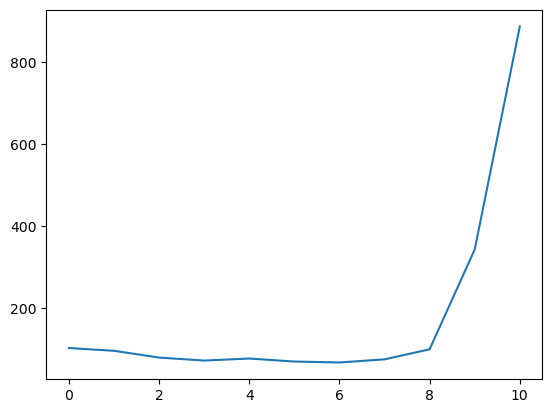

In [42]:
plt.plot(divided)
plt.show()

In the graph above we compare value counts of paths of length 2-6 and 7-10. We can see that 2-6 almost constantly holds higher value count ratio than 7-10. 2-6 Has almost 80 times more data compared to 7-10.

In [43]:
def path_count_per_length():
    for i in range(1,11):
        highways_raw = most_used_edges(length_list=[i])
        highways_filtered = highways_raw[highways_raw['Count']>2]
        print("Common subpath of length {} entry count: ".format(i), highways_filtered.size)

In [44]:
path_count_per_length()

Common subpath of length 1 entry count:  29882
Common subpath of length 2 entry count:  19032
Common subpath of length 3 entry count:  4670
Common subpath of length 4 entry count:  1014
Common subpath of length 5 entry count:  258
Common subpath of length 6 entry count:  136
Common subpath of length 7 entry count:  98
Common subpath of length 8 entry count:  66
Common subpath of length 9 entry count:  48
Common subpath of length 10 entry count:  34


We can see rapid decrease from 4-5 path reusage. Technically it should make sense to to subpaths of length 2-5 but we include 6 just to draw more interesting results, as subpaths of 6 may connect more peculiar areas.

### Determine bag of starting articles for each highway

In [45]:
def find_start_end_bags_using_highway(highway, df_finished):
    ## returns filter
    length = len(highway)
    start_words=set()
    end_words = set()
    for path in df_finished:
        if len(path) < length:
            continue
        for i in range(0,len(path)-length+1):
            tup = tuple(path[i:i+length])
            if tup == highway:
                if (i>=1):
                    start_words.add(path[i-1])
                if (i+length<len(path)):
                    end_words.add(path[i+length])
    return start_words, end_words

In [46]:
start, end = find_start_end_bags_using_highway(tuple(("Agriculture","Pea","Bean")),[['Pyramid','Mexico','Agriculture','Pea','Bean']])
print(start)
print(end)

{'Mexico'}
set()


<AxesSubplot: >

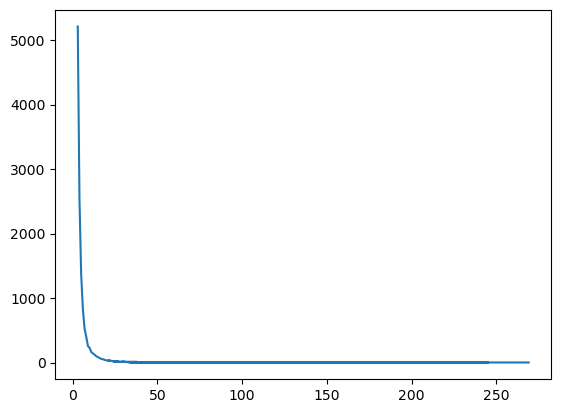

In [47]:
filtered_26 = highways_26_raw[highways_26_raw['Count']>2]
filtered_26['Count'].value_counts().plot()

We have a heavy tail distribution of value counts for times each path of different length is taken

Let's count from around 4 or more count since we still have some values

In [48]:
filtered_26_g5 = highways_26_raw[highways_26_raw['Count']>6]
high_to_st_end = {}
progress = 0
total_chunk = int(filtered_26_g5.size/200)
for highway in filtered_26_g5['Edge']:
    s, e = find_start_end_bags_using_highway(highway, df_finished_paths['path_list_without_backtracking'])
    high_to_st_end[highway] = [s,e]
    progress +=1
    if progress%total_chunk == 0:
        print((progress/total_chunk), "%")

1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %


## Data of highways connections

In [49]:
for k,v in high_to_st_end.items():
    print("Key" , k)
    print("Start Values", v[0])
    print("End Values", v[1])
    print("#"*200)

Key ('Fish', 'Whale_shark', 'Shark')
Start Values {'Dolphin', 'Albatross', 'Penguin', 'Great_Salt_Lake', 'Ocean', 'Pupil', 'Bird', 'Vertebrate', 'Humpback_Whale', 'Norway', 'Baltic_Sea', 'Chives', 'Orca', 'Whale', 'Fresh_water', 'Eye', 'Tuna', 'Owl', 'Water', 'Animal', 'Fishing', 'Horn_of_Africa', 'Cod', 'Jurassic', 'Evolution', 'Crocodile'}
End Values {'Animal', 'Fish', 'Tiger_shark', 'Great_white_shark', 'Angel_shark', 'Blacktip_reef_shark', 'Bull_shark', 'Zebra_shark', 'Basking_shark', 'Cookiecutter_shark', 'Blue_shark'}
########################################################################################################################################################################################################
Key ('Information', 'Communication', 'Telephone')
Start Values {'Writing', 'DNA', 'Philosophy_of_mind', 'Internet', 'Electronics', 'Computer_science', 'Cryptography', 'Market', 'Language'}
End Values {'Telecommunication'}
###############################################

## Building graphs

In [50]:
G = nx.Graph()
for k,v in high_to_st_end.items():
    ## Add nodes to graph
    for node in v[0]:
        G.add_node(node)
    for node in v[1]:
        G.add_node(node)
    
    ## Add edges
    for start_node in v[0]:
        for end_node in v[1]:
            G.add_edge(start_node,end_node)

In [51]:
nx.write_edgelist(G, "test.csv")

## Wiki2Vec

In [52]:
from wikipedia2vec import Wikipedia2Vec
MODEL_FILE = './data/enwiki_20180420_100d.pkl'
wiki2vec = Wikipedia2Vec.load(MODEL_FILE)

ModuleNotFoundError: No module named 'wikipedia2vec'

In [ ]:
wiki2vec.get_entity_vector('Leif Ericson').tolist()

In [ ]:
def article_to_wiki2vec_name(name):
    return name.replace('_',' ').replace("  ", " ")

def compute_average_vector(article_list):
    arrays = []
    for article in article_list:
        name = article_to_wiki2vec_name(article)
        try:
            vector = np.array(wiki2vec.get_entity_vector(name).tolist())
            arrays.append(vector)
        except:
            ## Sometimes articles are not found. They are removed or replaced by some other articles. Wikispeedia is older dataset than
            ## Wiki2vec model
            print("Not found: ", name)
    if len(arrays)== 0:
        return np.nan
    return np.mean(arrays, axis=0)

In [ ]:
l = ['Computer_science', 'Cryptography']
print(np.array(wiki2vec.get_entity_vector('Computer science')))
print(np.array(wiki2vec.get_entity_vector('Cryptography')))
compute_average_vector(l)

In [ ]:
highway_similarities = {}
for k,v in high_to_st_end.items():
    ## Ignore not existing highways might be bug
    if len(v[0])==0 or len(v[1])==0:
        continue
    
    start_vector = compute_average_vector(v[0])
    end_vector = compute_average_vector(v[1])
    if not np.isnan(start_vector).any() and not np.isnan(end_vector).any():
        # print("Highway: " , k)
        similarity = cosine_similarity([start_vector], [end_vector])
        highway_similarities[k] = similarity[0][0]
    #     print("Similarity: " , similarity)
    # print("#"*200)

In [ ]:
frequency, bins = np.histogram(list(highway_similarities.values()), bins=30, range=[0, 1])

In [ ]:
plt.hist(list(highway_similarities.values()), bins=15)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

We now have frequencies of similarity values between start and end points of highways. Now we need to choose a threshold to separate local(similar) highways between country highways.

In [ ]:
filtered_sims = {}
for k,v in highway_similarities.items():
    if v<0.2:
        filtered_sims[k] = v      

In [ ]:
for k in list(filtered_sims.keys()):
    print("Key: " , k)
    print("Start set: ", high_to_st_end[k][0])
    print("End set: ", high_to_st_end[k][1])

PCA?

In [ ]:
def get_vectors(article_list):
    arrays = []
    for article in article_list:
        name = article_to_wiki2vec_name(article)
        try:
            vector = np.array(wiki2vec.get_entity_vector(name).tolist())
            arrays.append(vector)
        except:
            ## Sometimes articles are not found. They are removed or replaced by some other articles. Wikispeedia is older dataset than
            ## Wiki2vec model
            print("Not found: ", name)
    return np.array(arrays)

In [ ]:
def compute_similarity_euclidean(X,Y):
    # Make matrices of 100x100
    return np.linalg.norm(np.matmul(X.T,X)- np.matmul(Y.T,Y))

In [ ]:
X = get_vectors(['Education_in_the_United_States', 'Science', 'Chemistry'])
Y = get_vectors(['Asteroid','Viking'])
compute_similarity_euclidean(X,Y)

In [ ]:
highway_similarities_euc = {}
for k,v in high_to_st_end.items():
    ## Ignore not existing highways might be bug
    if len(v[0])==0 or len(v[1])==0:
        continue
    
    start_vector = get_vectors(v[0])
    end_vector = get_vectors(v[1])
    if not np.isnan(start_vector).any() and not np.isnan(end_vector).any():
        # print("Highway: " , k)
        similarity = compute_similarity_euclidean(start_vector, end_vector)
        highway_similarities_euc[k] = similarity

In [ ]:
#normalize distances between 0 and 1
data_normed = preprocessing.scale(list(highway_similarities_euc.values()))
## replace values
i=0
for k in highway_similarities_euc:
    highway_similarities_euc[k] = data_normed[i]
    i+=1

In [ ]:
frequency, bins = np.histogram(list(highway_similarities_euc.values()), bins=30, range=[np.min(data_normed), np.max(data_normed)])
plt.hist(list(highway_similarities_euc.values()), bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [ ]:
filtered_sims = {}
for k,v in highway_similarities_euc.items():
    if v>4:
        filtered_sims[k] = v
for k in list(filtered_sims.keys()):
    print("Key: " , k)
    print("Start set: ", high_to_st_end[k][0])
    print("End set: ", high_to_st_end[k][1])